In [38]:
import pandas as pd
from collections import Counter
import re
import spacy
import pycountry
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df_data = pd.read_csv("/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/week0/Datasets/data.csv/rating.csv")
df_raw = pd.read_csv("/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/week0/Datasets/raw_data/data.csv")
df_traffic = pd.read_csv("/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/week0/Datasets/traffic_data/traffic.csv")
df_domains = pd.read_csv("/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/week0/Datasets/domains_location.csv")

In [3]:
df_data.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [4]:
df_raw.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
0,89541,NaN,International Business Times,Paavan MATHEMA,UN Chief Urges World To 'Stop The Madness' Of ...,UN Secretary-General Antonio Guterres urged th...,https://www.ibtimes.com/un-chief-urges-world-s...,https://d.ibtimes.com/en/full/4496078/nepals-g...,2023-10-30 10:12:35.000000,UN Secretary-General Antonio Guterres urged th...,Nepal,UN Secretary-General Antonio Guterres urged th...
1,89542,NaN,Prtimes.jp,NaN,RANDEBOOよりワンランク上の大人っぽさが漂うニットとベストが新登場。,[株式会社Ainer]\nRANDEBOO（ランデブー）では2023年7月18日(火)より公...,https://prtimes.jp/main/html/rd/p/000000147.00...,https://prtimes.jp/i/32220/147/ogp/d32220-147-...,2023-10-06 04:40:02.000000,"RANDEBOO2023718()WEB2023 Autumn Winter \n""Nepa...",Nepal,NaN
2,89543,NaN,VOA News,webdesk@voanews.com (Agence France-Presse),UN Chief Urges World to 'Stop the Madness' of ...,UN Secretary-General Antonio Guterres urged th...,https://www.voanews.com/a/un-chief-urges-world...,https://gdb.voanews.com/01000000-0a00-0242-60f...,2023-10-30 10:53:30.000000,"Kathmandu, Nepal UN Secretary-General Antonio...",Nepal,NaN
3,89545,NaN,The Indian Express,Editorial,Sikkim warning: Hydroelectricity push must be ...,Ecologists caution against the adverse effects...,https://indianexpress.com/article/opinion/edit...,https://images.indianexpress.com/2023/10/edit-...,2023-10-06 01:20:24.000000,At least 14 persons lost their lives and more ...,Nepal,At least 14 persons lost their lives and more ...
4,89547,NaN,The Times of Israel,Jacob Magid,"200 foreigners, dual nationals cut down in Ham...","France lost 35 citizens, Thailand 33, US 31, U...",https://www.timesofisrael.com/200-foreigners-d...,https://static.timesofisrael.com/www/uploads/2...,2023-10-27 01:08:34.000000,"Scores of foreign citizens were killed, taken ...",Nepal,NaN


In [5]:
df_traffic.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


In [6]:
df_domains.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


# EDA

Top and Bottom Websites that have the largest count of news articles

In [7]:
df_data['source_name'].head(10)

0                Forbes
1                   CNA
2                  Time
3              Phys.Org
4        Digital Trends
5    Al Jazeera English
6              BBC News
7              Phys.Org
8              Deadline
9              Euronews
Name: source_name, dtype: object

In [8]:
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Count the number of news articles for each website
website_article_counts = df_data['source_name'].value_counts()

# Convert the series to a DataFrame for easier manipulation
website_article_counts_df = pd.DataFrame(website_article_counts)
website_article_counts_df.reset_index(inplace=True)
website_article_counts_df.columns = ['Website', 'Article Count']

# Sort the websites based on their article counts in descending order to find the top 10
top_10_websites = website_article_counts_df.nlargest(10, 'Article Count')

# Sort the websites based on their article counts in ascending order to find the bottom 10
bottom_10_websites = website_article_counts_df.nsmallest(10, 'Article Count')

print("Top 10 websites with the largest count of news articles:")
print(top_10_websites)


Top 10 websites with the largest count of news articles:
              Website  Article Count
0      ETF Daily News          16746
1  The Times of India           7504
2       GlobeNewswire           5423
3  Globalsecurity.org           3119
4              Forbes           2784
5            BBC News           2113
6            ABC News           2058
7    Business Insider           2034
8           The Punch           1800
9  Al Jazeera English           1664


In [9]:
print("\nBottom 10 websites with the smallest count of news articles:")
print(bottom_10_websites)


Bottom 10 websites with the smallest count of news articles:
                        Website  Article Count
28  AllAfrica - Top Africa News             20
27                    The Verge            214
26                          CNN            267
25                        Wired            270
24                     Euronews            286
23                    ReadWrite            324
22                  Gizmodo.com            388
21              Android Central            522
20                         Time            600
19                          CNA            674


Top and Bottom 10 Websites with the highest numbers of visitors traffic

In [10]:
# Sorting the DataFrame by GlobalRank in ascending order to get the top 10
top_10_websites = df_traffic.sort_values(by='GlobalRank').head(10)

# Sorting the DataFrame by GlobalRank in descending order to get the bottom 10
bottom_10_websites = df_traffic.sort_values(by='GlobalRank', ascending=False).head(10)

print("Top 10 Websites with the Highest Visitor Traffic:")
print(top_10_websites[['Domain', 'GlobalRank']])

print("\nBottom 10 Websites with the Lowest Visitor Traffic:")
print(bottom_10_websites[['Domain', 'GlobalRank']])

Top 10 Websites with the Highest Visitor Traffic:
                 Domain  GlobalRank
0            google.com           1
1          facebook.com           2
2           youtube.com           3
3           twitter.com           4
4         instagram.com           5
5          linkedin.com           6
6             apple.com           7
7         microsoft.com           8
8  googletagmanager.com           9
9         wikipedia.org          10

Bottom 10 Websites with the Lowest Visitor Traffic:
                        Domain  GlobalRank
999999  toyotamusicfactory.com     1000000
999998          soderhomes.com      999999
999997           pinkwater.com      999998
999996             mt-lock.com      999997
999995              kireie.com      999996
999994         keith-baker.com      999995
999993          irishcycle.com      999994
999992                hmag.com      999993
999991    exploring-africa.com      999992
999990            eiretrip.com      999991


Top and Bottom 10 Countries with the highest number of news media organisations (represented by domains in the data)

In [11]:
# Grouping the DataFrame by 'location' and counting the number of unique domains for each country
country_counts = df_domains.groupby('location')['SourceCommonName'].nunique().reset_index()

# Sorting the DataFrame by the counts of unique domains in descending order to get the top 10
top_10_countries = country_counts.sort_values(by='SourceCommonName', ascending=False).head(10)

# Sorting the DataFrame by the counts of unique domains in ascending order to get the bottom 10
bottom_10_countries = country_counts.sort_values(by='SourceCommonName').head(10)

print("Top 10 Countries with the Highest Number of News Media Organizations:")
print(top_10_countries)

print("\nBottom 10 Countries with the Lowest Number of News Media Organizations:")
print(bottom_10_countries)

Top 10 Countries with the Highest Number of News Media Organizations:
    location  SourceCommonName
210       US             14111
208       UK              1946
98        IT              1804
70        FR              1039
172       RS              1020
34        CA               886
79        GM               884
40        CH               779
202       TU               725
94        IN               686

Bottom 10 Countries with the Lowest Number of News Media Organizations:
    location  SourceCommonName
0         AA                 1
80        GP                 1
45        CN                 1
93        IM                 1
77        GK                 1
164       PU                 1
157       PC                 1
10        AQ                 1
179       SH                 1
155       OS                 1


Top and Bottom 10 Countries that have many articles written about them - the content of the news is about that country

In [12]:

df_data['content'].head()

0    Pavyllon London, at Four Seasons Hotel London ...
1    Nice moved into provisional first place in the...
2    The worlds frogs, salamanders, newts and other...
3    Iron-rich sediment colors the red-orange water...
4    Everything ends. No, I’m not having an existen...
Name: content, dtype: object

In [13]:
# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

# Function to extract country mentions from text using spaCy
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return countries

# Apply the function to extract country mentions from the content column
df_data['country_mentions'] = df_data['content'].apply(extract_countries)

# Flatten the list of country mentions
country_mentions_flat = [country for sublist in df_data['country_mentions'] for country in sublist]

# Count the occurrences of each country mention
country_counts = pd.Series(country_mentions_flat).value_counts()

# Display the top and bottom 10 countries mentioned in the articles
top_10_countries = country_counts.head(10)
bottom_10_countries = country_counts.tail(10)

print("Top 10 countries mentioned in the articles:")
print(top_10_countries)

print("\nBottom 10 countries mentioned in the articles:")
print(bottom_10_countries)

Top 10 countries mentioned in the articles:
Israel      1862
India       1559
Gaza        1125
US          1119
Ukraine      897
U.S.         866
China        837
Russia       716
Dublin       656
New York     629
Name: count, dtype: int64

Bottom 10 countries mentioned in the articles:
Masis                     1
Zipcar                    1
NORRISTOWN                1
North Rhine-Westphalia    1
Makhachkala               1
Littlehampton             1
Kingston                  1
Melina                    1
Ehang                     1
Gaza City’s               1
Name: count, dtype: int64


Top and Bottom Websites that reported (the news content) about Africa, US, China, EU, Russia, Ukraine, Middle East? Note that you will need to group countries together to form the African, EU, and Middle East continents/regions.

In [14]:
df_domains['Country'].head()

0      Senegal
1       France
2        Italy
3    Argentina
4        China
Name: Country, dtype: object

In [15]:
# List of countries, regions, and continents
countries_list = [
    'us', 'usa', 'united states', 'united states of america', 'america', 'united states of',
    'china', 'prc', 'people\'s republic of china',
    'russia', 'russian federation', 'soviet union', 'ussr',
    'ukraine', 'ukr', 'ukrainian',
    'middle east', 'middle eastern', 'mideast',
    'africa', 'african',
    'north america', 'north american', 'na',  # For USA
    'asia', 'asian', 'cn'  # For China
]

# Function to extract countries/regions from text
def extract_countries(text):
    doc = nlp(text)
    countries = [ent.text.lower() for ent in doc.ents if ent.label_ == "GPE" and ent.text.lower() in countries_list]
    return countries

# Apply the function to extract countries from content column
df_data['mentioned_countries'] = df_data['content'].apply(extract_countries)

# Count mentions of each country/region
df_data['mentioned_countries_count'] = df_data['mentioned_countries'].apply(len)

# Group by source_name and sum the counts of mentions
grouped_by_source = df_data.groupby('source_name')['mentioned_countries_count'].sum()

# Sort the groups by counts of mentions
sorted_sources = grouped_by_source.sort_values(ascending=False)

# Extract top and bottom 10 sources
top_10_sources = sorted_sources.head(10)
bottom_10_sources = sorted_sources.tail(10)

print("Top 10 sources reporting news about the regions:")
print(top_10_sources)
print("\nBottom 10 sources reporting news about the regions:")
print(bottom_10_sources)

Top 10 sources reporting news about the regions:
source_name
Globalsecurity.org              708
RT                              545
GlobeNewswire                   469
Business Insider                467
The Times of India              361
Al Jazeera English              272
BBC News                        230
International Business Times    226
ABC News                        194
Forbes                           98
Name: mentioned_countries_count, dtype: int64

Bottom 10 sources reporting news about the regions:
source_name
Phys.Org                       33
Boing Boing                    24
ReadWrite                      23
Wired                          11
The Verge                      10
Deadline                        8
Android Central                 4
Gizmodo.com                     4
Digital Trends                  2
AllAfrica - Top Africa News     0
Name: mentioned_countries_count, dtype: int64


Top and Bottom 10 Websites with the highest count of positive, neutral, and negative sentiment?

In [16]:
df_data['url'].head()

0    https://www.forbes.com/sites/elizabethbrownfie...
1    https://www.channelnewsasia.com/sport/nice-cla...
2    https://time.com/6320467/amphibians-most-vulne...
3    https://phys.org/news/2023-10-image-rusty-red-...
4    https://www.digitaltrends.com/movies/everythin...
Name: url, dtype: object

In [17]:
# Function to extract domain from URL
def extract_domain(url):
    try:
        parsed_uri = urlparse(url)
        if parsed_uri.scheme == '' or parsed_uri.netloc == '':
            return None
        domain = '{uri.netloc}'.format(uri=parsed_uri)
        return domain
    except:
        return None

# Apply the function to extract domain from the 'url' column
df_data['domain'] = df_data['url'].apply(extract_domain)

# Group the data by website domain and sentiment, then count the occurrences
sentiment_counts = df_data.groupby(['domain', 'title_sentiment']).size().unstack(fill_value=0)

# Calculate total count of sentiments for each website
sentiment_counts['Total'] = sentiment_counts.sum(axis=1)

# Sort the websites based on total count of each sentiment
top_bottom_website_sentiments = sentiment_counts.sort_values(by='Total', ascending=False)

# Extract top and bottom 10 websites for each sentiment
top_positive = top_bottom_website_sentiments.nlargest(10, 'Positive')['Positive']
top_neutral = top_bottom_website_sentiments.nlargest(10, 'Neutral')['Neutral']
top_negative = top_bottom_website_sentiments.nlargest(10, 'Negative')['Negative']

bottom_positive = top_bottom_website_sentiments.nsmallest(10, 'Positive')['Positive']
bottom_neutral = top_bottom_website_sentiments.nsmallest(10, 'Neutral')['Neutral']
bottom_negative = top_bottom_website_sentiments.nsmallest(10, 'Negative')['Negative']

print("Top 10 Websites with the highest count of positive sentiment:")
print(top_positive)
print("\nTop 10 Websites with the highest count of neutral sentiment:")
print(top_neutral)
print("\nTop 10 Websites with the highest count of negative sentiment:")
print(top_negative)

print("\nBottom 10 Websites with the lowest count of positive sentiment:")
print(bottom_positive)
print("\nBottom 10 Websites with the lowest count of neutral sentiment:")
print(bottom_neutral)
print("\nBottom 10 Websites with the lowest count of negative sentiment:")
print(bottom_negative)

Top 10 Websites with the highest count of positive sentiment:
domain
www.etfdailynews.com            992
economictimes.indiatimes.com    932
www.globenewswire.com           905
www.forbes.com                  635
www.digitaltrends.com           406
www.androidcentral.com          272
www.businessinsider.com         237
timesofindia.indiatimes.com     213
boingboing.net                  170
www.marketscreener.com          153
Name: Positive, dtype: int64

Top 10 Websites with the highest count of neutral sentiment:
domain
www.etfdailynews.com            15194
www.globenewswire.com            4491
economictimes.indiatimes.com     3634
www.globalsecurity.org           2255
www.forbes.com                   1933
timesofindia.indiatimes.com      1515
punchng.com                      1229
abcnews.go.com                   1193
www.marketscreener.com           1167
www.bbc.co.uk                    1135
Name: Neutral, dtype: int64

Top 10 Websites with the highest count of negative sentiment:
do

Comparing the impact of using mean/average and median

In [18]:
# Group the data by website domain and sentiment, then calculate mean sentiment counts
mean_sentiment_counts = df_data.groupby('domain')['title_sentiment'].value_counts(normalize=True).unstack(fill_value=0)

# Calculate mean sentiment counts for each website
mean_sentiment_counts['Mean_Total'] = mean_sentiment_counts.sum(axis=1)

# Sort the websites based on mean total count of each sentiment
mean_top_bottom_websites = mean_sentiment_counts.sort_values(by='Mean_Total', ascending=False)

# Repeat the same process for median sentiment counts
median_sentiment_counts = df_data.groupby('domain')['title_sentiment'].value_counts().unstack(fill_value=0)
median_sentiment_counts['Median_Total'] = median_sentiment_counts.sum(axis=1)
median_top_bottom_websites = median_sentiment_counts.sort_values(by='Median_Total', ascending=False)

# Compare the top and bottom websites based on mean vs median sentiment counts for each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"Top 10 Websites with the highest count of {sentiment.lower()} sentiment (using Mean):")
    print(mean_top_bottom_websites[sentiment].nlargest(10))
    print(f"\nTop 10 Websites with the highest count of {sentiment.lower()} sentiment (using Median):")
    print(median_top_bottom_websites[sentiment].nlargest(10))
    print("\n")

    print(f"Bottom 10 Websites with the lowest count of {sentiment.lower()} sentiment (using Mean):")
    print(mean_top_bottom_websites[sentiment].nsmallest(10))
    print(f"\nBottom 10 Websites with the lowest count of {sentiment.lower()} sentiment (using Median):")
    print(median_top_bottom_websites[sentiment].nsmallest(10))
    print("\n")


Top 10 Websites with the highest count of positive sentiment (using Mean):
domain
www.androidcentral.com              0.521073
www.digitaltrends.com               0.517857
cnaluxury.channelnewsasia.com       0.500000
cnalifestyle.channelnewsasia.com    0.333333
www.theverge.com                    0.285047
www.wired.com                       0.248148
boingboing.net                      0.238429
www.forbes.com                      0.228089
readwrite.com                       0.216049
economictimes.indiatimes.com        0.175518
Name: Positive, dtype: float64

Top 10 Websites with the highest count of positive sentiment (using Median):
domain
www.etfdailynews.com            992
economictimes.indiatimes.com    932
www.globenewswire.com           905
www.forbes.com                  635
www.digitaltrends.com           406
www.androidcentral.com          272
www.businessinsider.com         237
timesofindia.indiatimes.com     213
boingboing.net                  170
www.marketscreener.com      

Check the distribution of Sentiments for a particular domain

In [19]:
df_data['domain'].head()

0             www.forbes.com
1    www.channelnewsasia.com
2                   time.com
3                   phys.org
4      www.digitaltrends.com
Name: domain, dtype: object

In [20]:
# Group by domain and calculate the number of articles for each domain
domain_article_counts = df_data['domain'].value_counts()

# Select the top 10 domains by number of articles
top_10_domains = domain_article_counts.nlargest(10).index

# Filter df_data to include only articles from the top 10 domains
df_top_10_domains = df_data[df_data['domain'].isin(top_10_domains)]

# Calculate sentiment distribution for each domain
domain_sentiment_distribution = df_top_10_domains.groupby(['domain', 'title_sentiment']).size().unstack(fill_value=0)

# Calculate global news sentiment distribution
global_sentiment_distribution = df_data['title_sentiment'].value_counts(normalize=True) * 100

# Print the sentiment distributions for each domain and the global news sentiment distribution
print("Sentiment Distribution for Top 10 Domains:")
print(domain_sentiment_distribution)

print("\nGlobal News Sentiment Distribution:")
print(global_sentiment_distribution)

Sentiment Distribution for Top 10 Domains:
title_sentiment               Negative  Neutral  Positive
domain                                                   
abcnews.go.com                     726     1193       139
economictimes.indiatimes.com       744     3634       932
punchng.com                        455     1229       116
timesofindia.indiatimes.com        466     1515       213
www.bbc.co.uk                      828     1135        69
www.businessinsider.com            890      907       237
www.etfdailynews.com               560    15194       992
www.forbes.com                     216     1933       635
www.globalsecurity.org             747     2255       117
www.globenewswire.com               27     4491       905

Global News Sentiment Distribution:
title_sentiment
Neutral     73.558846
Negative    15.650490
Positive    10.790664
Name: proportion, dtype: float64


How similar are the raw message lengths across sites

<Figure size 1000x600 with 0 Axes>

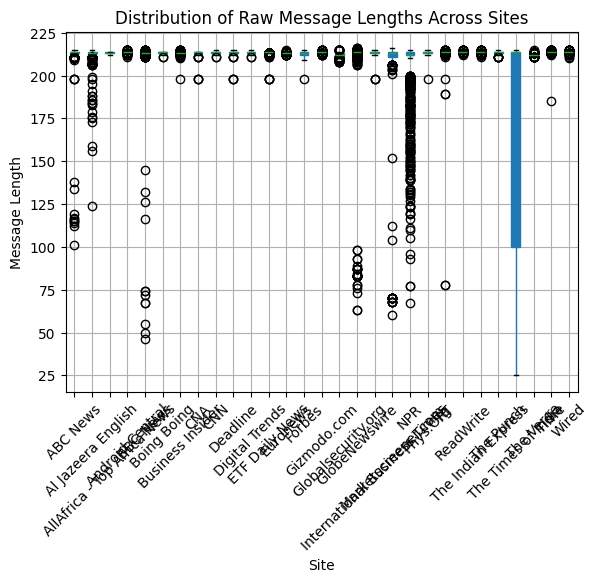

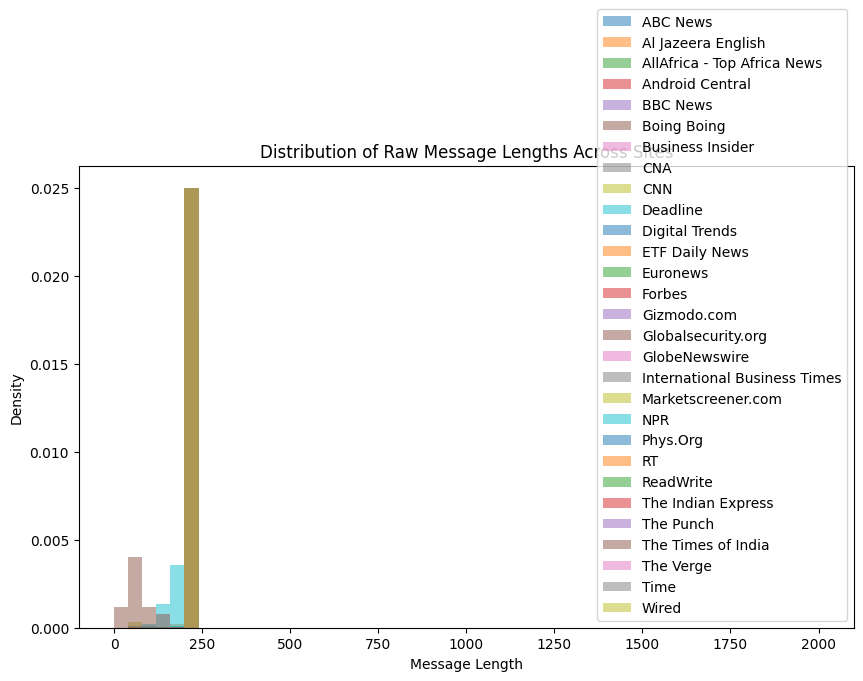

In [21]:
# Extract relevant data and create a copy to avoid the warning
relevant_data = df_data[['source_name', 'content']].copy()

# Calculate raw message lengths using .loc to set values explicitly
relevant_data.loc[:, 'message_length'] = relevant_data['content'].apply(lambda x: len(str(x)))

# Group by Site and Calculate Descriptive Statistics
stats_by_site = relevant_data.groupby('source_name')['message_length'].describe()

# 4. Visualize the Distribution
plt.figure(figsize=(10, 6))
boxplot = relevant_data.boxplot(column='message_length', by='source_name', patch_artist=True)
plt.title('Distribution of Raw Message Lengths Across Sites')
plt.suptitle('')
plt.xlabel('Site')
plt.ylabel('Message Length')
plt.xticks(rotation=45)
plt.show()

# Alternatively, you can also plot histograms for better understanding of the distribution
plt.figure(figsize=(10, 6))
for site, data in relevant_data.groupby('source_name'):
    plt.hist(data['message_length'], bins=50, alpha=0.5, label=site, density=True, range=(0, 2000))  
plt.title('Distribution of Raw Message Lengths Across Sites')
plt.xlabel('Message Length')
plt.ylabel('Density')
plt.legend()
plt.show()

How similar are the number of words in the title across sites

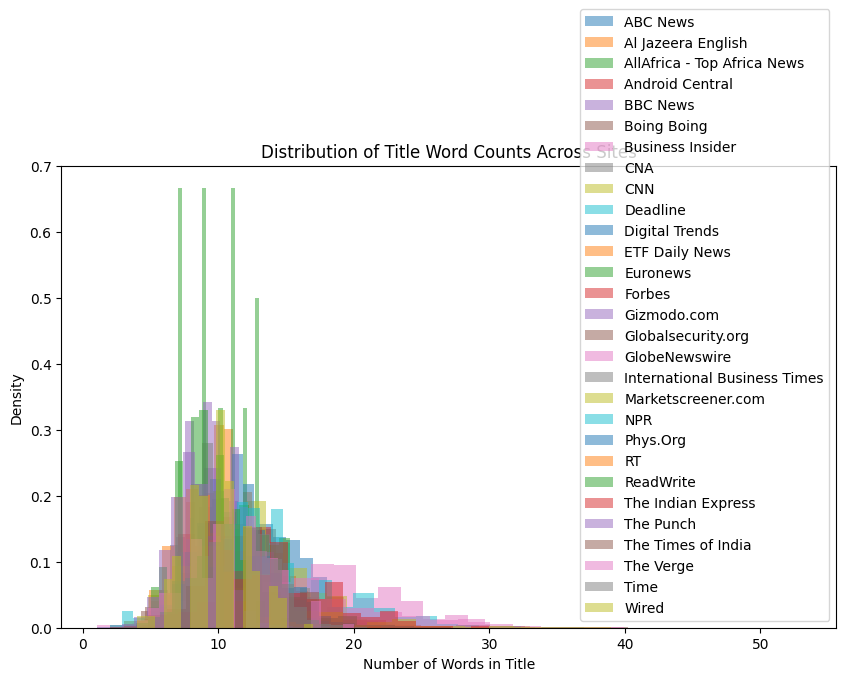

In [22]:
# Extract relevant data and create a copy to avoid the warning
relevant_data = df_data[['source_name', 'title']].copy()

# Calculate the number of words in the title
relevant_data['title_word_count'] = relevant_data['title'].apply(lambda x: len(str(x).split()))

# Plot histograms with adjusted scale (increased number of bins and adjusted range)
plt.figure(figsize=(10, 6))
for site, data in relevant_data.groupby('source_name'):
    plt.hist(data['title_word_count'], bins=20, alpha=0.5, label=site, density=True)  
plt.title('Distribution of Title Word Counts Across Sites')
plt.xlabel('Number of Words in Title')
plt.ylabel('Density')
plt.legend()
plt.show()

The impact of frequent news reporting and sentiment to the website’s global ranking

In [23]:
df_traffic.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


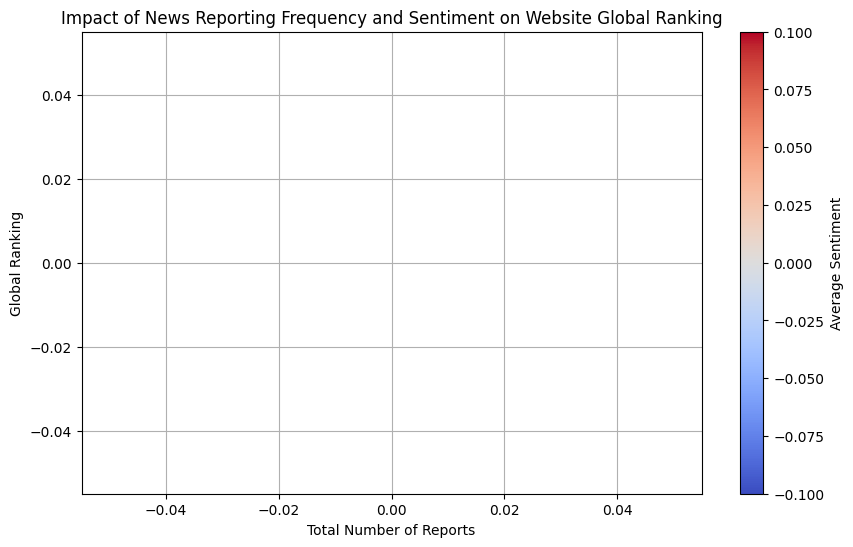

In [24]:
# Calculate total number of reports by each website
report_counts = df_data['source_name'].value_counts().reset_index()
report_counts.columns = ['source_name', 'report_count']

# Convert sentiment strings to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df_data['title_sentiment_numeric'] = df_data['title_sentiment'].map(sentiment_mapping)

# Aggregate average sentiment for each website
avg_sentiment = df_data.groupby('source_name')['title_sentiment_numeric'].mean().reset_index()
avg_sentiment.columns = ['source_name', 'avg_sentiment']

# Aggregate global ranking for each website
global_ranking = df_traffic.groupby('Domain')['GlobalRank'].mean().reset_index()
global_ranking.columns = ['source_name', 'GlobalRank']

# Merge aggregated data
merged_data = pd.merge(report_counts, avg_sentiment, on='source_name', how='outer')
merged_data = pd.merge(merged_data, global_ranking, on='source_name', how='outer')

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['report_count'], merged_data['GlobalRank'], c=merged_data['avg_sentiment'], cmap='coolwarm')
plt.colorbar(label='Average Sentiment')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Ranking')
plt.title('Impact of News Reporting Frequency and Sentiment on Website Global Ranking')
plt.grid(True)
plt.show()

# Data Preparation

## Data.csv

In [25]:
df_data.shape

(58356, 18)

In [26]:
df_data.isnull().sum()

article_id                       0
source_id                    40585
source_name                      0
author                        2163
title                            0
description                     10
url                              0
url_to_image                  3451
published_at                     0
content                          0
category                        21
article                          0
title_sentiment                  0
country_mentions                 0
mentioned_countries              0
mentioned_countries_count        0
domain                           0
title_sentiment_numeric          0
dtype: int64

### Handling Missing Values

In [27]:
# Calculating the percentage of missing values
missing_percentage = (df_data.isnull().sum() / len(df_data)) * 100
print(missing_percentage)

article_id                    0.000000
source_id                    69.547262
source_name                   0.000000
author                        3.706560
title                         0.000000
description                   0.017136
url                           0.000000
url_to_image                  5.913702
published_at                  0.000000
content                       0.000000
category                      0.035986
article                       0.000000
title_sentiment               0.000000
country_mentions              0.000000
mentioned_countries           0.000000
mentioned_countries_count     0.000000
domain                        0.000000
title_sentiment_numeric       0.000000
dtype: float64


In [28]:
# Drop the source_id column as it contain 69% missing values
df_data = df_data.drop(columns=['source_id'])

# Replace missing values in text columns with 'Unknown'
df_data['author'].fillna('Unknown', inplace=True)
df_data['description'] = df_data['description'].fillna('Not Available')
df_data['url_to_image'] = df_data['url_to_image'].fillna('Not Available')
df_data['category'] = df_data['category'].fillna('Unknown')

/tmp/ipykernel_6049/4049499887.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_data['author'].fillna('Unknown', inplace=True)


## Domain_location.csv

In [29]:
df_domains.isnull().sum()

SourceCommonName    0
location            0
Country             1
dtype: int64

### Handling Missing Value

In [30]:
# Mode imputation for the 'Country' column
mode_country = df_domains['Country'].mode()[0]
df_domains['Country'].fillna(mode_country, inplace=True)

/tmp/ipykernel_6049/2988200844.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_domains['Country'].fillna(mode_country, inplace=True)


## Traffic_data.csv

In [31]:
df_traffic.isnull().sum()

GlobalRank        0
TldRank           0
Domain            0
TLD               0
RefSubNets        0
RefIPs            0
IDN_Domain        0
IDN_TLD           0
PrevGlobalRank    0
PrevTldRank       0
PrevRefSubNets    0
PrevRefIPs        0
dtype: int64

In [32]:
df_domains['Country'].head()

0      Senegal
1       France
2        Italy
3    Argentina
4        China
Name: Country, dtype: object

# Text Preprocessing

Keyword extraction/modelling using TF-IDF

In [33]:
nltk.download('wordnet')

# Function to preprocess text
def preprocess_text(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove emoticons
    text = re.sub(r':\)|;\)|:-\)|:-\(|:-D|:-\(|:-\)|:D|:P|:S|:\||:O|:\(|:\-D|:\-S', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Function to perform TF-IDF vectorization and keyword extraction
def extract_keywords(df_data):
    # Apply text preprocessing to 'content' column
    df_data['clean_content'] = df_data['content'].apply(preprocess_text)
    
    # Perform TF-IDF vectorization with even higher max_features
    tfidf_vectorizer = TfidfVectorizer(max_features=20000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_data['clean_content'])

    # Get feature names (words)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    print("Feature Names:")
    print(feature_names)

    # Create a DataFrame from TF-IDF matrix
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Identify top keywords
    top_keywords = tfidf_df.sum().sort_values(ascending=False).head(10)
    return top_keywords


# Sample data preprocessing and keyword extraction
top_keywords = extract_keywords(df_data)

# Display top keywords
print("Top Keywords:", top_keywords)

[nltk_data] Downloading package wordnet to /home/moraa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Top Keywords: char         3368.444669
report       2949.980128
free         2207.032488
share        1776.154538
quarter      1647.558724
company      1642.279215
according    1610.643146
2023         1570.683964
inc          1549.994285
recent       1498.832874
dtype: float64


Similarity Search

In [34]:
# Convert values in the 'title' column to strings only if they are convertible
df_data['title'] = df_data['title'].apply(lambda x: str(x) if isinstance(x, str) else x)


In [35]:
print(df_data['title'].apply(type).value_counts())

title
<class 'str'>    58356
Name: count, dtype: int64


In [36]:
# Check the data type of the 'title' column
print(df_data['title'].dtype)

object


In [37]:
# Function to calculate cosine similarity between headline/title and news body for a subset of articles
def calculate_similarity_subset(df_data, sample_size=1000):
    # Sample subset of articles
    df_sample = df_data.sample(n=sample_size, random_state=42)
    
    # Apply text preprocessing to 'title' and 'content' columns
    df_sample['clean_title'] = df_sample['title'].apply(preprocess_text)
    df_sample['clean_content'] = df_sample['content'].apply(preprocess_text)
    
    # Perform TF-IDF vectorization for title
    tfidf_vectorizer_title = TfidfVectorizer(max_features=1000)
    tfidf_matrix_title = tfidf_vectorizer_title.fit_transform(df_sample['clean_title'])
    
    # Perform TF-IDF vectorization for content
    tfidf_vectorizer_content = TfidfVectorizer(max_features=1000)
    tfidf_matrix_content = tfidf_vectorizer_content.fit_transform(df_sample['clean_content'])
    
    # Calculate cosine similarity between title and content vectors
    similarity_scores = cosine_similarity(tfidf_matrix_title, tfidf_matrix_content)
    
    return similarity_scores

# Calculate similarity scores for a subset of articles
similarity_scores_subset = calculate_similarity_subset(df_data)

# Aggregate similarity scores across all articles
overall_similarity_subset = similarity_scores_subset.mean()

print("Overall similarity between keywords in headline/title and news body across sites (subset):", overall_similarity_subset)
 

Overall similarity between keywords in headline/title and news body across sites (subset): 0.007113328391785348


In [39]:
# Function to perform topic modeling using LDA
def perform_topic_modeling(df_data, num_topics=5):
    # Apply text preprocessing to 'content' column
    df_data['clean_content'] = df_data['content'].apply(preprocess_text)
    
    # Create document-term matrix using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    dtm = vectorizer.fit_transform(df_data['clean_content'])
    
    # Fit LDA model
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    
    return lda_model, vectorizer

# Perform topic modeling
num_topics = 5  # You can adjust the number of topics as needed
lda_model, vectorizer = perform_topic_modeling(df_data, num_topics)

# Function to display top words for each topic
def display_topics(model, vectorizer, num_top_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Display top words for each topic
display_topics(lda_model, vectorizer)

Topic 1:
char october 2023 november president minister gaza israel said state

Topic 2:
char new year world india said image getty state time

Topic 3:
report char quarter according free recent share company filing second

Topic 4:
2023 char nov globe newswire market global company billion new

Topic 5:
report free char share stock traded rating price research company

